In [1]:
import datetime
import os

import tensorflow as tf
from tensorflow.keras import backend as k
from tensorflow.keras.layers import (Flatten,Dense,Reshape,Conv2D,MaxPool2D,Conv2DTranspose)
import matplotlib.pyplot as plt
plt.rcParams['image.cmap']='Greys_r'

In [2]:
#Loading the training and test sets from tfrecords
raw_training_dataset = tf.data.TFRecordDataset('data/train_images.tfrecords')
raw_val_dataset = tf.data.TFRecordDataset('data/val_images.tfrecords')

In [3]:
# dictionary describing the fields stored in TFRecord, and used to extract the date from the TFRecords
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

In [4]:
#helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto,image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset = raw_val_dataset.map(_parse_image_function)

In [5]:
print(len(list(parsed_training_dataset)))
print(len(list(parsed_val_dataset)))

234
26


In [6]:
#function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'],tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw,[256,256,1])
    
    image = tf.cast(image,tf.float32)*(1. /1024)
    
    label_raw = tf.io.decode_raw(example['label_raw'],tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw,[256,256,1])
    
    return image,label

In [7]:
# get datasets read and decoded and into a state usable by tensorflow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(
    read_and_decode,num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [8]:
#setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1

In [9]:
# setup the train and test data by shuffling,prefetching,etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset = val.batch(BATCH_SIZE)
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>

In [10]:
# Helper function to display an image,its label and the prediction
def display(display_list):
    plt.figure(figsize=(10,10))
    title = ['Input Image','Label','Predicted Label']
    
    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i],[256,256])
        plt.subplot(1,len(display_list),i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

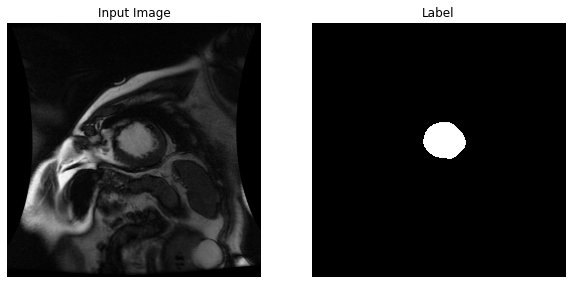

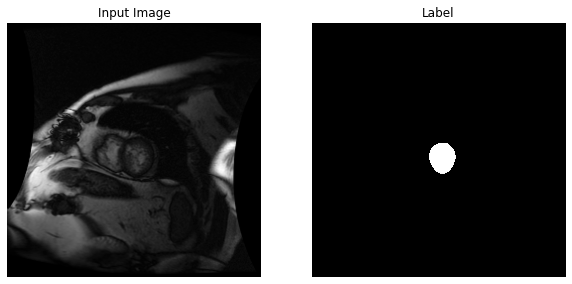

In [11]:
# display an image and label from the training set
for image,label in train.take(2):
    sample_image,sample_label = image,label
    display([sample_image,sample_label])

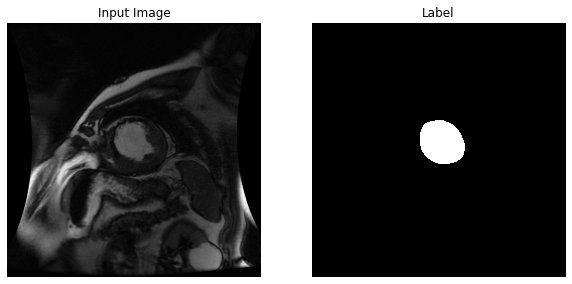

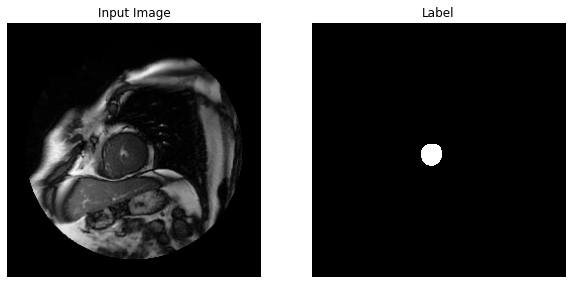

In [12]:
# display an image and label from the test set
for image,label in val.take(2):
    sample_image,sample_label = image,label
    display([sample_image,sample_label])

In [13]:
tf.keras.backend.clear_session()

#set up the model architecture
model = tf.keras.models.Sequential([
    Flatten(input_shape=[256,256,1]),
    Dense(64,activation='relu'),
    Dense(256*256*2, activation='softmax'),
    Reshape((256,256,2))  
])

# specify how to train the model with algorith,the loss function and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [14]:
# print out the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4194368   
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            8519680   
_________________________________________________________________
reshape (Reshape)            (None, 256, 256, 2)       0         
Total params: 12,714,048
Trainable params: 12,714,048
Non-trainable params: 0
_________________________________________________________________


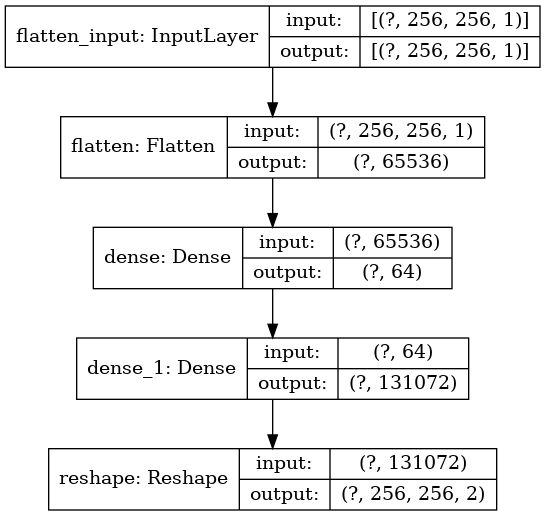

In [15]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model,show_shapes=True)

In [16]:
# function to take a prediction from the model and output an image for display
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask,axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]
    return pred_mask[0]


In [17]:
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0],label[0],create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis,...]))
        display([sample_image,sample_label,prediction])
        

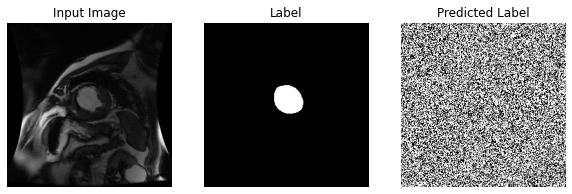

In [18]:
# show a prediction, as an example
show_predictions(test_dataset)


In [19]:
# define a callback that shows image predictions on the test set
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,log=None):
        show_predictions()
        print('\nSample prediction after epoch {}\n'.format(epoch+1))
        
# setup a tensorboard callback
logdir = os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


Train for 234 steps, validate for 26 steps
Epoch 1/20
223/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5030

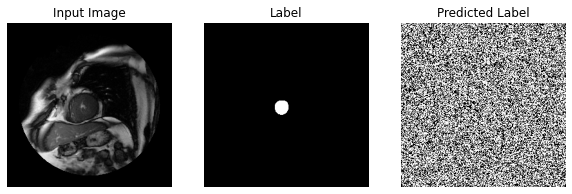


Sample prediction after epoch 1

234/234 [==============================] - 3s 12ms/step - loss: 0.6931 - accuracy: 0.5034 - val_loss: 0.6931 - val_accuracy: 0.5101
Epoch 2/20
226/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5173

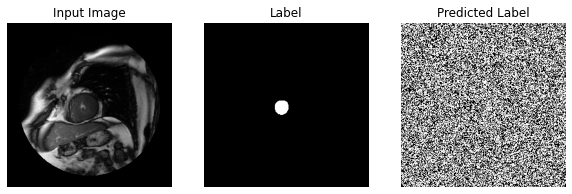


Sample prediction after epoch 2

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.5177 - val_loss: 0.6931 - val_accuracy: 0.5269
Epoch 3/20
233/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5356

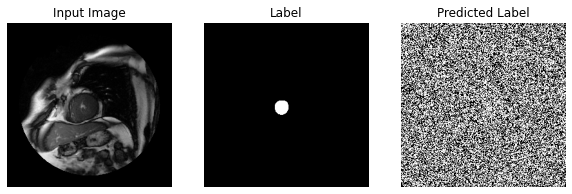


Sample prediction after epoch 3

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.5357 - val_loss: 0.6931 - val_accuracy: 0.5467
Epoch 4/20
224/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5624

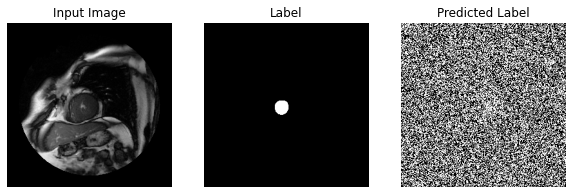


Sample prediction after epoch 4

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.5634 - val_loss: 0.6931 - val_accuracy: 0.5875
Epoch 5/20
223/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.6296

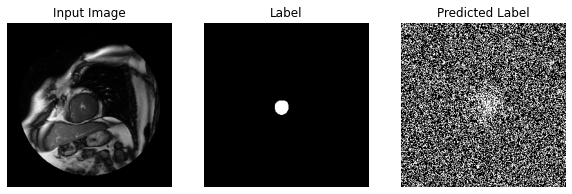


Sample prediction after epoch 5

234/234 [==============================] - 2s 10ms/step - loss: 0.6931 - accuracy: 0.6325 - val_loss: 0.6931 - val_accuracy: 0.6954
Epoch 6/20
229/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.7891

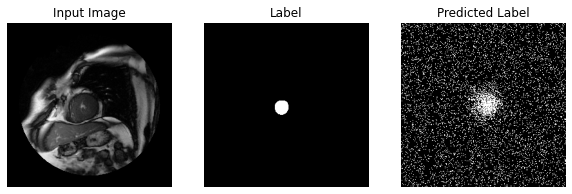


Sample prediction after epoch 6

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.7915 - val_loss: 0.6931 - val_accuracy: 0.9005
Epoch 7/20
225/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9595

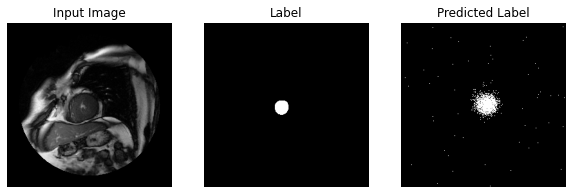


Sample prediction after epoch 7

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9605 - val_loss: 0.6931 - val_accuracy: 0.9855
Epoch 8/20
222/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9864

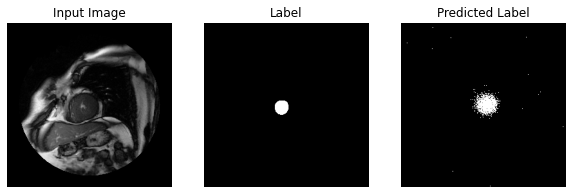


Sample prediction after epoch 8

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9864 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 9/20
233/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9866

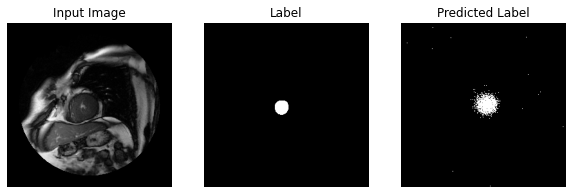


Sample prediction after epoch 9

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9865 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 10/20
223/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9865

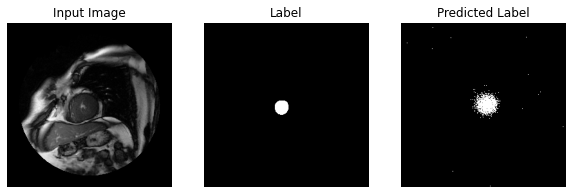


Sample prediction after epoch 10

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9865 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 11/20
225/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9866

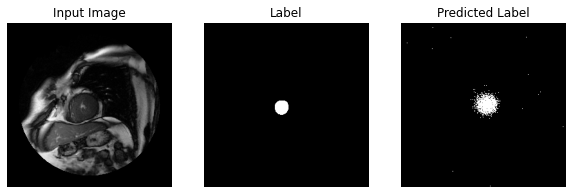


Sample prediction after epoch 11

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9865 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 12/20
225/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9866

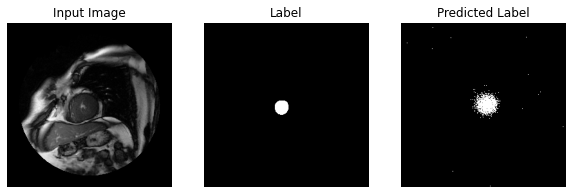


Sample prediction after epoch 12

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9865 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 13/20
233/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9866

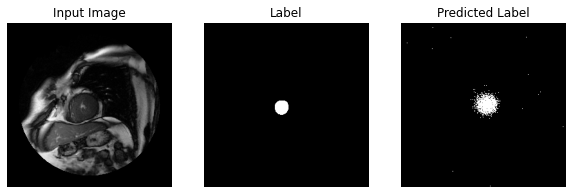


Sample prediction after epoch 13

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9865 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 14/20
225/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9865

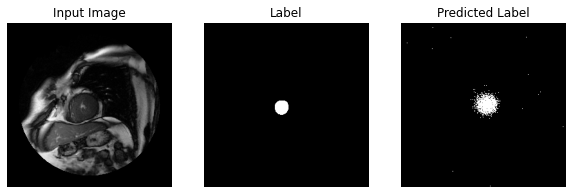


Sample prediction after epoch 14

234/234 [==============================] - 2s 10ms/step - loss: 0.6931 - accuracy: 0.9865 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 15/20
227/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9865

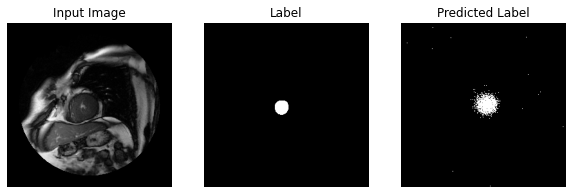


Sample prediction after epoch 15

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9865 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 16/20
226/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9865

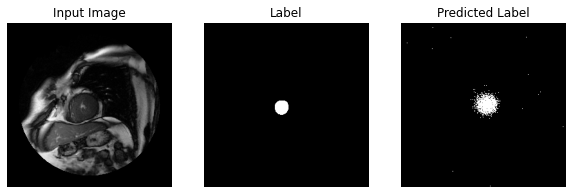


Sample prediction after epoch 16

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9865 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 17/20
223/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9866

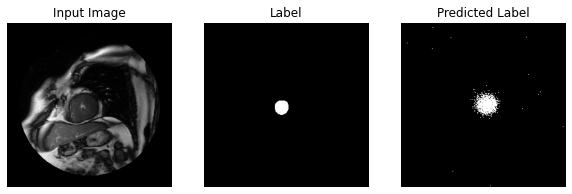


Sample prediction after epoch 17

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9865 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 18/20
222/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9865

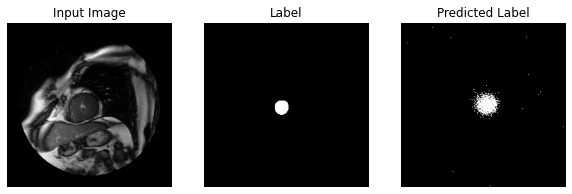


Sample prediction after epoch 18

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9865 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 19/20
230/234 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.9866

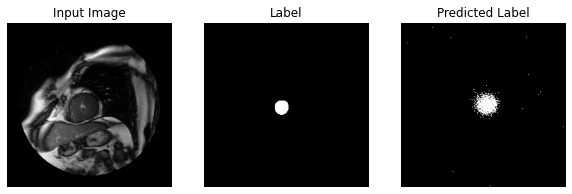


Sample prediction after epoch 19

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9865 - val_loss: 0.6931 - val_accuracy: 0.9865
Epoch 20/20
223/234 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.9864

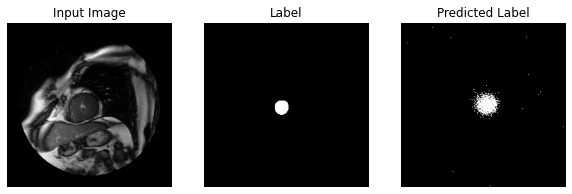


Sample prediction after epoch 20

234/234 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.9865 - val_loss: 0.6931 - val_accuracy: 0.9865


In [20]:
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

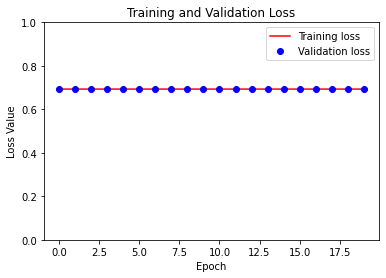

In [21]:
#output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs,loss,'r',label='Training loss')
plt.plot(epochs,val_loss,'bo',label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0,1])
plt.legend()
plt.show()

In [22]:
model.evaluate(test_dataset)

     26/Unknown - 0s 5ms/step - loss: 0.6931 - accuracy: 0.9865

[0.6931405067443848, 0.98654354]

In [23]:
%load_ext tensorboard

In [24]:
%tensorboard --logdir logs

In [25]:
model.evaluate(test_dataset)

     26/Unknown - 0s 3ms/step - loss: 0.6931 - accuracy: 0.9865

[0.6931405067443848, 0.98654354]

In [26]:
tf.keras.backend.clear_session()

layers = [
    Conv2D(input_shape=[256,256,1],
          filters=100,
          kernel_size=5,
          strides=2,
          padding="same",
          activation=tf.nn.relu,
          name='Conv1'),
    MaxPool2D(pool_size=2,strides=2,padding="same"),
    Conv2D(filters=200,
          kernel_size=5,
          strides=2,
          padding="same",
          activation=tf.nn.relu),
    MaxPool2D(pool_size=2,strides=2,padding="same"),
    Conv2D(filters=300,
          kernel_size=3,
          strides=1,
          padding="same",
          activation=tf.nn.relu),
    Conv2D(filters=300,
          kernel_size=3,
          strides=1,
          padding="same",
          activation=tf.nn.relu),
    Conv2D(filters=2,
          kernel_size=1,
          strides=1,
          padding="same",
          activation=tf.nn.relu),
    Conv2DTranspose(filters=2,kernel_size=31,strides=16,padding="same")
]

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])



In [27]:
#print out the summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 128, 128, 100)     2600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 200)       500200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 300)       540300    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 300)       810300    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 2)         6

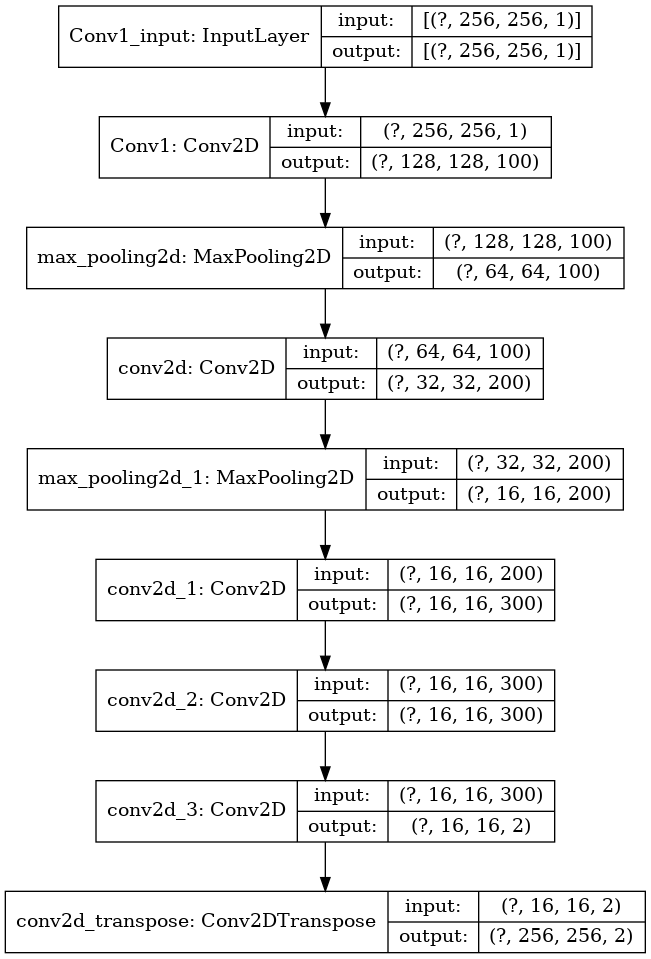

In [28]:
#plot the model including the size of the model
tf.keras.utils.plot_model(model,show_shapes=True)

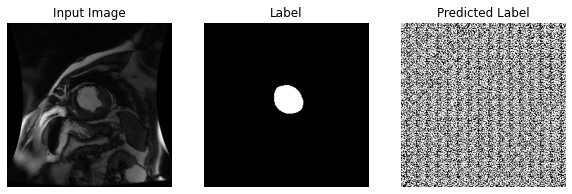

In [29]:
#show a prediction as an example
show_predictions(test_dataset)


In [30]:
# Initialise new directories for new task
logdir = os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback= tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

Train for 234 steps, validate for 26 steps
Epoch 1/20
231/234 [============================>.] - ETA: 0s - loss: 0.1011 - accuracy: 0.9689

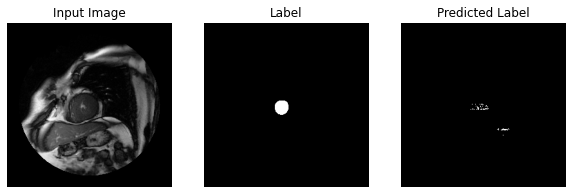


Sample prediction after epoch 1

234/234 [==============================] - 3s 13ms/step - loss: 0.1002 - accuracy: 0.9691 - val_loss: 0.0465 - val_accuracy: 0.9830
Epoch 2/20
225/234 [===========================>..] - ETA: 0s - loss: 0.0412 - accuracy: 0.9851

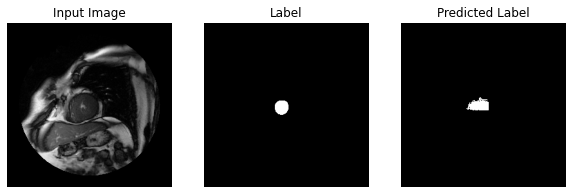


Sample prediction after epoch 2

234/234 [==============================] - 2s 7ms/step - loss: 0.0409 - accuracy: 0.9851 - val_loss: 0.0329 - val_accuracy: 0.9872
Epoch 3/20
230/234 [============================>.] - ETA: 0s - loss: 0.0267 - accuracy: 0.9899

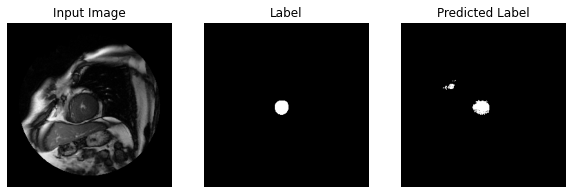


Sample prediction after epoch 3

234/234 [==============================] - 2s 7ms/step - loss: 0.0268 - accuracy: 0.9898 - val_loss: 0.0229 - val_accuracy: 0.9904
Epoch 4/20
227/234 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 0.9922

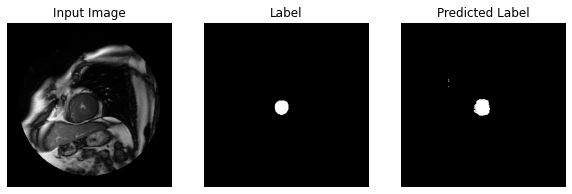


Sample prediction after epoch 4

234/234 [==============================] - 2s 7ms/step - loss: 0.0197 - accuracy: 0.9922 - val_loss: 0.0186 - val_accuracy: 0.9927
Epoch 5/20
229/234 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9942

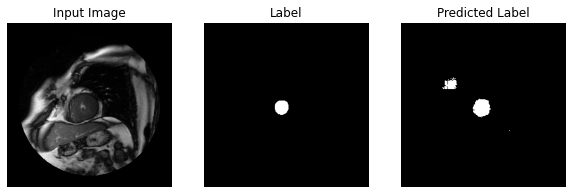


Sample prediction after epoch 5

234/234 [==============================] - 2s 7ms/step - loss: 0.0145 - accuracy: 0.9942 - val_loss: 0.0149 - val_accuracy: 0.9938
Epoch 6/20
228/234 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9952

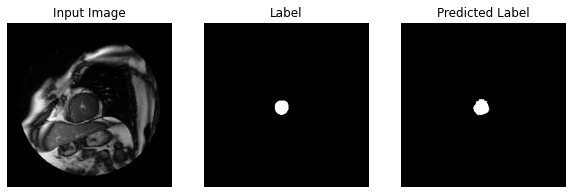


Sample prediction after epoch 6

234/234 [==============================] - 2s 7ms/step - loss: 0.0118 - accuracy: 0.9952 - val_loss: 0.0153 - val_accuracy: 0.9939
Epoch 7/20
227/234 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.9959

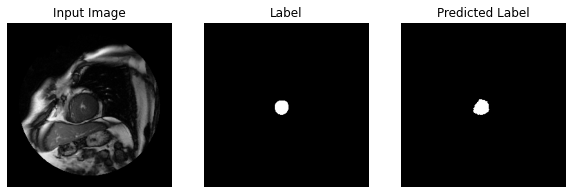


Sample prediction after epoch 7

234/234 [==============================] - 2s 7ms/step - loss: 0.0099 - accuracy: 0.9959 - val_loss: 0.0111 - val_accuracy: 0.9955
Epoch 8/20
227/234 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9964

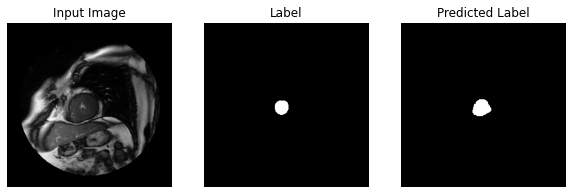


Sample prediction after epoch 8

234/234 [==============================] - 2s 7ms/step - loss: 0.0087 - accuracy: 0.9964 - val_loss: 0.0094 - val_accuracy: 0.9961
Epoch 9/20
230/234 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9969

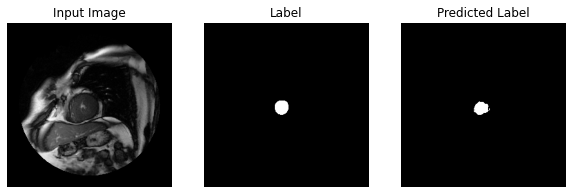


Sample prediction after epoch 9

234/234 [==============================] - 2s 7ms/step - loss: 0.0074 - accuracy: 0.9969 - val_loss: 0.0119 - val_accuracy: 0.9957
Epoch 10/20
226/234 [===========================>..] - ETA: 0s - loss: 0.0064 - accuracy: 0.9973

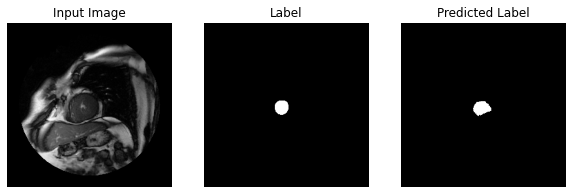


Sample prediction after epoch 10

234/234 [==============================] - 2s 7ms/step - loss: 0.0065 - accuracy: 0.9973 - val_loss: 0.0089 - val_accuracy: 0.9965
Epoch 11/20
228/234 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9976

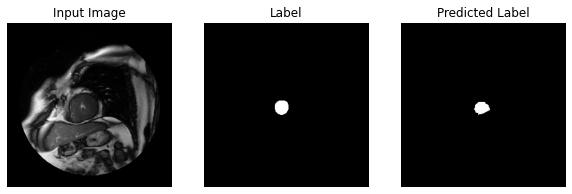


Sample prediction after epoch 11

234/234 [==============================] - 2s 7ms/step - loss: 0.0058 - accuracy: 0.9976 - val_loss: 0.0081 - val_accuracy: 0.9968
Epoch 12/20
228/234 [============================>.] - ETA: 0s - loss: 0.0052 - accuracy: 0.9978

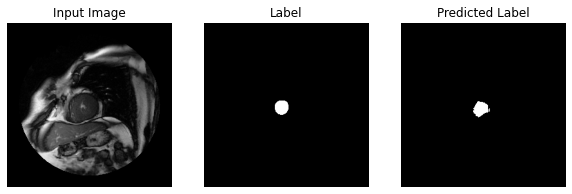


Sample prediction after epoch 12

234/234 [==============================] - 2s 7ms/step - loss: 0.0052 - accuracy: 0.9978 - val_loss: 0.0090 - val_accuracy: 0.9965
Epoch 13/20
227/234 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9979

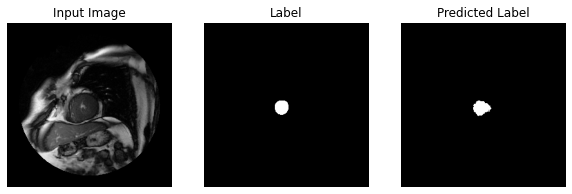


Sample prediction after epoch 13

234/234 [==============================] - 2s 7ms/step - loss: 0.0050 - accuracy: 0.9979 - val_loss: 0.0116 - val_accuracy: 0.9955
Epoch 14/20
228/234 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9980

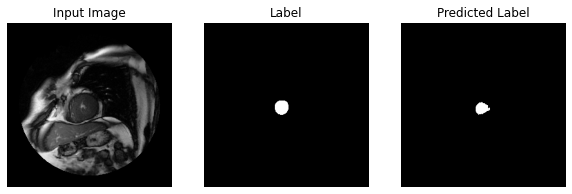


Sample prediction after epoch 14

234/234 [==============================] - 2s 7ms/step - loss: 0.0048 - accuracy: 0.9980 - val_loss: 0.0096 - val_accuracy: 0.9967
Epoch 15/20
225/234 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9980

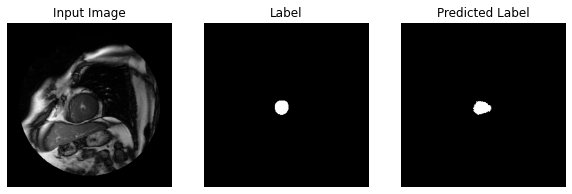


Sample prediction after epoch 15

234/234 [==============================] - 2s 7ms/step - loss: 0.0046 - accuracy: 0.9980 - val_loss: 0.0085 - val_accuracy: 0.9968
Epoch 16/20
227/234 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9980

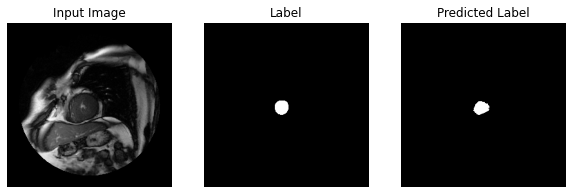


Sample prediction after epoch 16

234/234 [==============================] - 2s 7ms/step - loss: 0.0047 - accuracy: 0.9980 - val_loss: 0.0076 - val_accuracy: 0.9970
Epoch 17/20
228/234 [============================>.] - ETA: 0s - loss: 0.0052 - accuracy: 0.9978

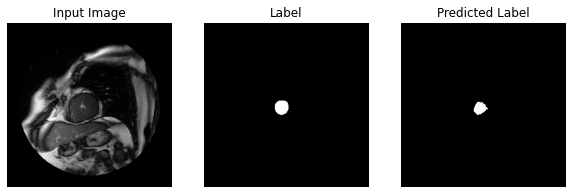


Sample prediction after epoch 17

234/234 [==============================] - 2s 7ms/step - loss: 0.0052 - accuracy: 0.9979 - val_loss: 0.0079 - val_accuracy: 0.9971
Epoch 18/20
228/234 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9983

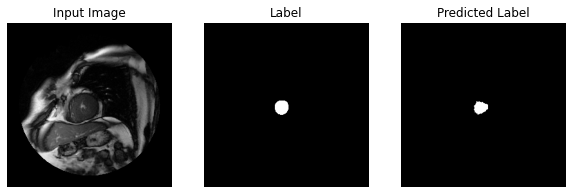


Sample prediction after epoch 18

234/234 [==============================] - 2s 7ms/step - loss: 0.0040 - accuracy: 0.9983 - val_loss: 0.0071 - val_accuracy: 0.9973
Epoch 19/20
229/234 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9984

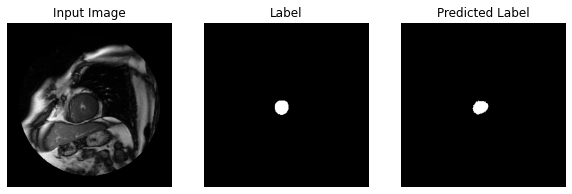


Sample prediction after epoch 19

234/234 [==============================] - 2s 7ms/step - loss: 0.0038 - accuracy: 0.9984 - val_loss: 0.0085 - val_accuracy: 0.9970
Epoch 20/20
228/234 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9985

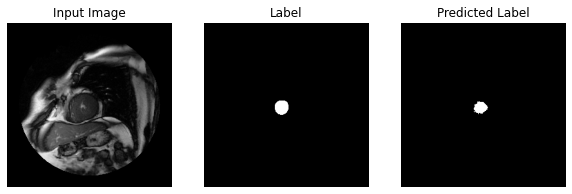


Sample prediction after epoch 20

234/234 [==============================] - 2s 7ms/step - loss: 0.0035 - accuracy: 0.9985 - val_loss: 0.0078 - val_accuracy: 0.9973


In [31]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset,epochs=EPOCHS,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_steps=VALIDATION_STEPS,
                         validation_data=test_dataset,
                         callbacks=[DisplayCallback(),tensorboard_callback])

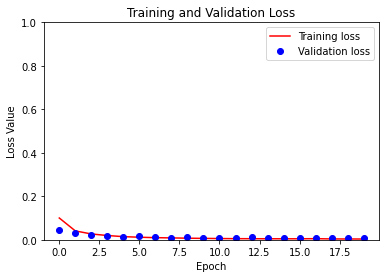

In [37]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs,loss,'r',label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [36]:
model.evaluate(test_dataset)

     26/Unknown - 0s 5ms/step - loss: 0.0078 - accuracy: 0.9973

[0.007754302628409977, 0.99731624]

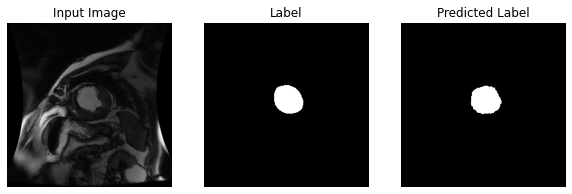

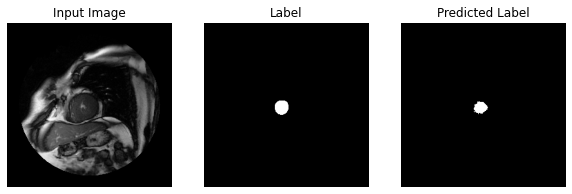

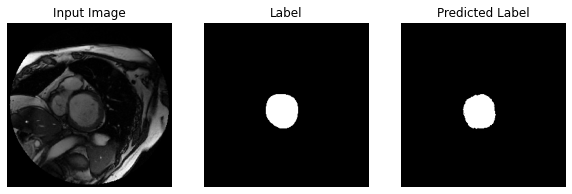

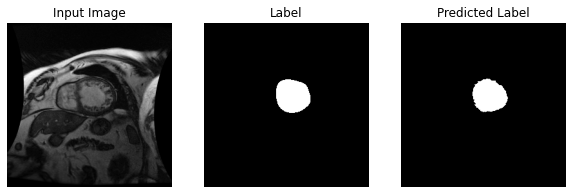

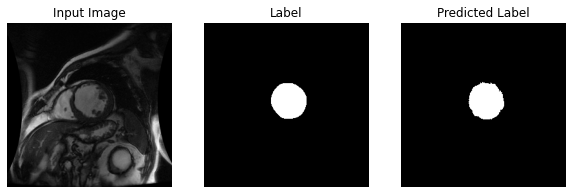

In [34]:
# show predictions from the test data set that has NOT been used for training.
show_predictions(test_dataset, 5)

In [40]:
def dice_coef(y_true,y_pred,smooth=1):
    indices = k.argmax(y_pred,3)
    indices = k.reshape(indices,[-1,256,256,1])
    
    true_cast = y_true
    indices_cast = k.cast(indices,dtype='float32')
    
    axis = [1,2,3]
    intersection = k.sum(true_cast*indices_cast,axis=axis)
    union = k.sum(true_cast,axis=axis) + k.sum(indices_cast,axis=axis)
    dice = k.mean((2.*intersection + smooth)/(union + smooth),axis=0)
    
    return dice

In [41]:
# initialize new directories for new task
logdir = os.path.join("logs",datetime.datetime.now().strftime("Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)

In [42]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[dice_coef,'accuracy'])

Train for 234 steps
Epoch 1/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0038 - dice_coef: 0.9189 - accuracy: 0.9984

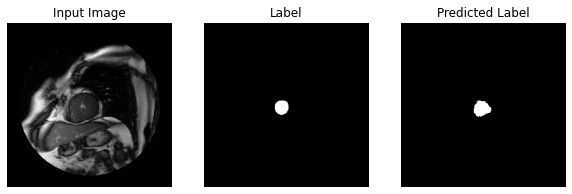


Sample prediction after epoch 1

234/234 [==============================] - 2s 9ms/step - loss: 0.0038 - dice_coef: 0.9185 - accuracy: 0.9984 - val_loss: 0.0094 - val_dice_coef: 0.8299 - val_accuracy: 0.9964
Epoch 2/30
228/234 [============================>.] - ETA: 0s - loss: 0.0038 - dice_coef: 0.9230 - accuracy: 0.9984

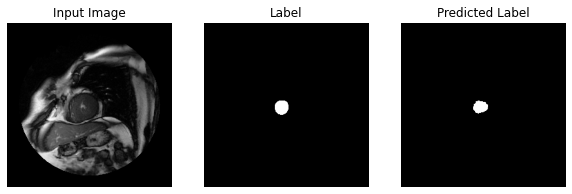


Sample prediction after epoch 2

234/234 [==============================] - 1s 6ms/step - loss: 0.0038 - dice_coef: 0.9197 - accuracy: 0.9984 - val_loss: 0.0081 - val_dice_coef: 0.8192 - val_accuracy: 0.9969
Epoch 3/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0036 - dice_coef: 0.9290 - accuracy: 0.9985

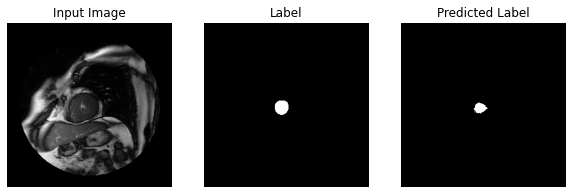


Sample prediction after epoch 3

234/234 [==============================] - 1s 6ms/step - loss: 0.0036 - dice_coef: 0.9291 - accuracy: 0.9985 - val_loss: 0.0078 - val_dice_coef: 0.8322 - val_accuracy: 0.9973
Epoch 4/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0033 - dice_coef: 0.9270 - accuracy: 0.9986

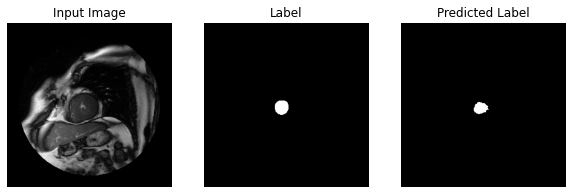


Sample prediction after epoch 4

234/234 [==============================] - 1s 6ms/step - loss: 0.0033 - dice_coef: 0.9278 - accuracy: 0.9986 - val_loss: 0.0084 - val_dice_coef: 0.8418 - val_accuracy: 0.9974
Epoch 5/30
228/234 [============================>.] - ETA: 0s - loss: 0.0030 - dice_coef: 0.9380 - accuracy: 0.9987

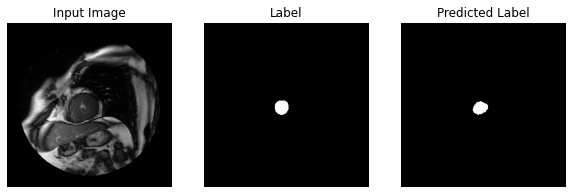


Sample prediction after epoch 5

234/234 [==============================] - 1s 6ms/step - loss: 0.0030 - dice_coef: 0.9385 - accuracy: 0.9987 - val_loss: 0.0082 - val_dice_coef: 0.8390 - val_accuracy: 0.9974
Epoch 6/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0032 - dice_coef: 0.9286 - accuracy: 0.9986

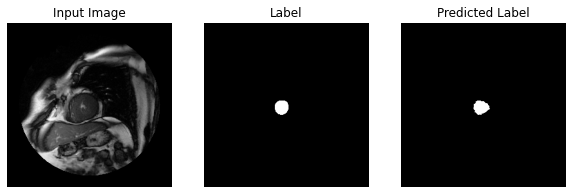


Sample prediction after epoch 6

234/234 [==============================] - 1s 6ms/step - loss: 0.0032 - dice_coef: 0.9283 - accuracy: 0.9986 - val_loss: 0.0090 - val_dice_coef: 0.8407 - val_accuracy: 0.9969
Epoch 7/30
227/234 [============================>.] - ETA: 0s - loss: 0.0032 - dice_coef: 0.9291 - accuracy: 0.9986

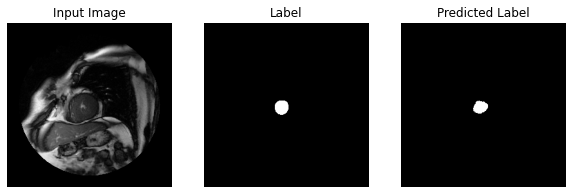


Sample prediction after epoch 7

234/234 [==============================] - 1s 6ms/step - loss: 0.0032 - dice_coef: 0.9285 - accuracy: 0.9986 - val_loss: 0.0077 - val_dice_coef: 0.8424 - val_accuracy: 0.9974
Epoch 8/30
224/234 [===========================>..] - ETA: 0s - loss: 0.0030 - dice_coef: 0.9337 - accuracy: 0.9987

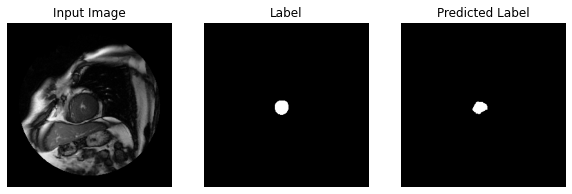


Sample prediction after epoch 8

234/234 [==============================] - 2s 6ms/step - loss: 0.0030 - dice_coef: 0.9335 - accuracy: 0.9987 - val_loss: 0.0085 - val_dice_coef: 0.8339 - val_accuracy: 0.9973
Epoch 9/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0030 - dice_coef: 0.9369 - accuracy: 0.9987

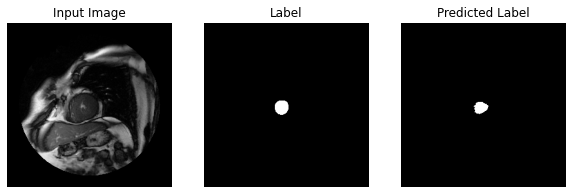


Sample prediction after epoch 9

234/234 [==============================] - 1s 6ms/step - loss: 0.0030 - dice_coef: 0.9366 - accuracy: 0.9987 - val_loss: 0.0085 - val_dice_coef: 0.8339 - val_accuracy: 0.9973
Epoch 10/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0030 - dice_coef: 0.9347 - accuracy: 0.9987

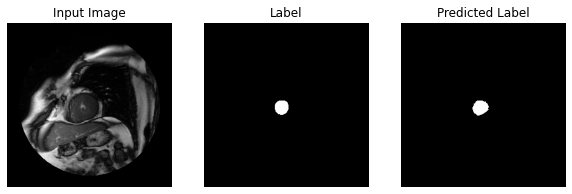


Sample prediction after epoch 10

234/234 [==============================] - 1s 6ms/step - loss: 0.0030 - dice_coef: 0.9324 - accuracy: 0.9987 - val_loss: 0.0083 - val_dice_coef: 0.8546 - val_accuracy: 0.9973
Epoch 11/30
228/234 [============================>.] - ETA: 0s - loss: 0.0027 - dice_coef: 0.9391 - accuracy: 0.9988

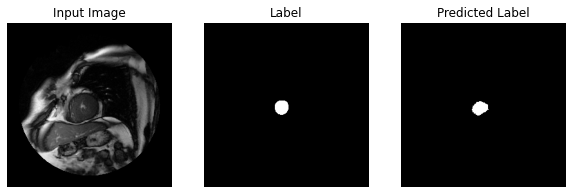


Sample prediction after epoch 11

234/234 [==============================] - 1s 6ms/step - loss: 0.0027 - dice_coef: 0.9389 - accuracy: 0.9988 - val_loss: 0.0075 - val_dice_coef: 0.8497 - val_accuracy: 0.9976
Epoch 12/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0033 - dice_coef: 0.9237 - accuracy: 0.9986

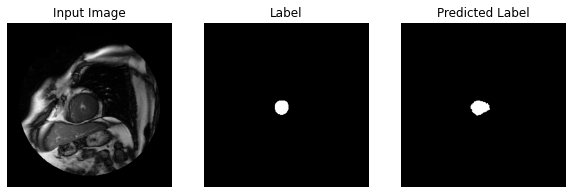


Sample prediction after epoch 12

234/234 [==============================] - 1s 6ms/step - loss: 0.0033 - dice_coef: 0.9250 - accuracy: 0.9986 - val_loss: 0.0085 - val_dice_coef: 0.8481 - val_accuracy: 0.9972
Epoch 13/30
228/234 [============================>.] - ETA: 0s - loss: 0.0029 - dice_coef: 0.9367 - accuracy: 0.9988

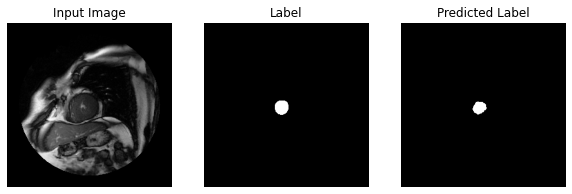


Sample prediction after epoch 13

234/234 [==============================] - 1s 6ms/step - loss: 0.0029 - dice_coef: 0.9357 - accuracy: 0.9988 - val_loss: 0.0086 - val_dice_coef: 0.8416 - val_accuracy: 0.9973
Epoch 14/30
227/234 [============================>.] - ETA: 0s - loss: 0.0025 - dice_coef: 0.9429 - accuracy: 0.9989

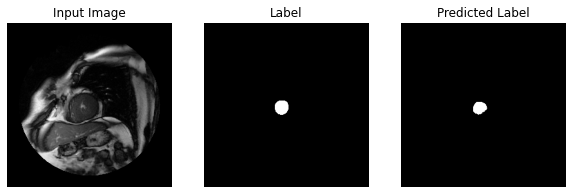


Sample prediction after epoch 14

234/234 [==============================] - 1s 6ms/step - loss: 0.0025 - dice_coef: 0.9431 - accuracy: 0.9989 - val_loss: 0.0082 - val_dice_coef: 0.8493 - val_accuracy: 0.9976
Epoch 15/30
233/234 [============================>.] - ETA: 0s - loss: 0.0025 - dice_coef: 0.9464 - accuracy: 0.9989

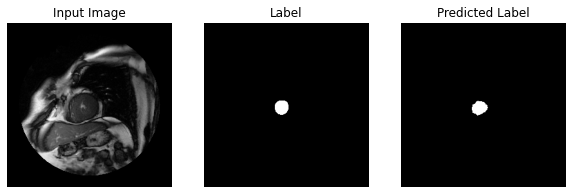


Sample prediction after epoch 15

234/234 [==============================] - 1s 6ms/step - loss: 0.0025 - dice_coef: 0.9466 - accuracy: 0.9989 - val_loss: 0.0090 - val_dice_coef: 0.8401 - val_accuracy: 0.9973
Epoch 16/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0026 - dice_coef: 0.9475 - accuracy: 0.9989

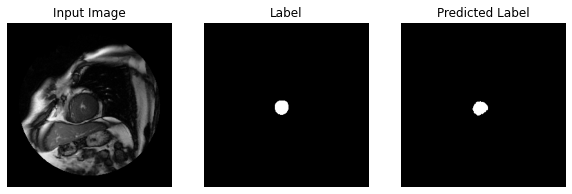


Sample prediction after epoch 16

234/234 [==============================] - 1s 6ms/step - loss: 0.0026 - dice_coef: 0.9485 - accuracy: 0.9989 - val_loss: 0.0074 - val_dice_coef: 0.8475 - val_accuracy: 0.9976
Epoch 17/30
224/234 [===========================>..] - ETA: 0s - loss: 0.0026 - dice_coef: 0.9447 - accuracy: 0.9989

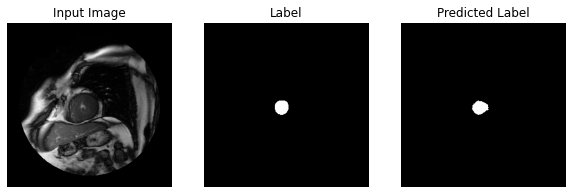


Sample prediction after epoch 17

234/234 [==============================] - 1s 6ms/step - loss: 0.0026 - dice_coef: 0.9450 - accuracy: 0.9989 - val_loss: 0.0086 - val_dice_coef: 0.8601 - val_accuracy: 0.9974
Epoch 18/30
228/234 [============================>.] - ETA: 0s - loss: 0.0027 - dice_coef: 0.9443 - accuracy: 0.9989

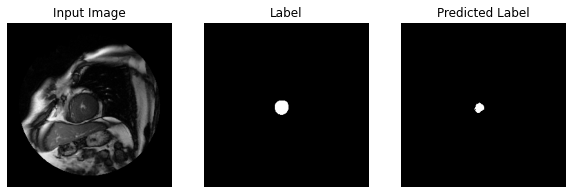


Sample prediction after epoch 18

234/234 [==============================] - 2s 7ms/step - loss: 0.0027 - dice_coef: 0.9449 - accuracy: 0.9989 - val_loss: 0.0109 - val_dice_coef: 0.8283 - val_accuracy: 0.9972
Epoch 19/30
224/234 [===========================>..] - ETA: 0s - loss: 0.0027 - dice_coef: 0.9430 - accuracy: 0.9989

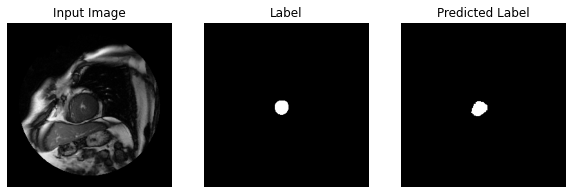


Sample prediction after epoch 19

234/234 [==============================] - 1s 6ms/step - loss: 0.0026 - dice_coef: 0.9430 - accuracy: 0.9989 - val_loss: 0.0083 - val_dice_coef: 0.8491 - val_accuracy: 0.9975
Epoch 20/30
224/234 [===========================>..] - ETA: 0s - loss: 0.0023 - dice_coef: 0.9463 - accuracy: 0.9990

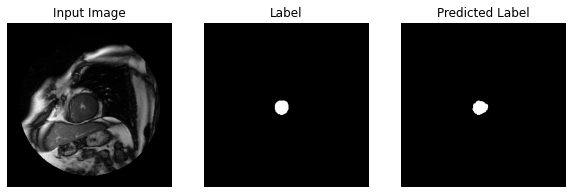


Sample prediction after epoch 20

234/234 [==============================] - 1s 6ms/step - loss: 0.0023 - dice_coef: 0.9468 - accuracy: 0.9990 - val_loss: 0.0087 - val_dice_coef: 0.8482 - val_accuracy: 0.9975
Epoch 21/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0023 - dice_coef: 0.9495 - accuracy: 0.9990

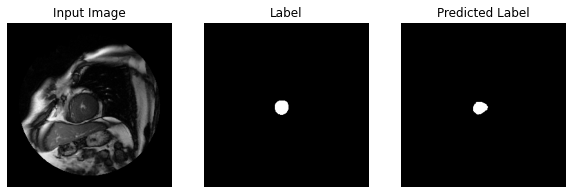


Sample prediction after epoch 21

234/234 [==============================] - 1s 6ms/step - loss: 0.0023 - dice_coef: 0.9494 - accuracy: 0.9990 - val_loss: 0.0091 - val_dice_coef: 0.8622 - val_accuracy: 0.9975
Epoch 22/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0023 - dice_coef: 0.9542 - accuracy: 0.9990

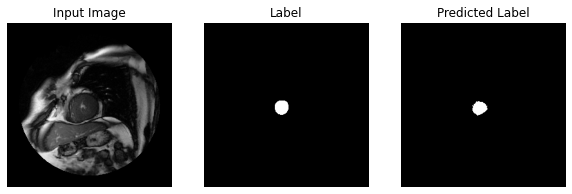


Sample prediction after epoch 22

234/234 [==============================] - 1s 6ms/step - loss: 0.0023 - dice_coef: 0.9543 - accuracy: 0.9990 - val_loss: 0.0095 - val_dice_coef: 0.8471 - val_accuracy: 0.9975
Epoch 23/30
228/234 [============================>.] - ETA: 0s - loss: 0.0024 - dice_coef: 0.9478 - accuracy: 0.9990

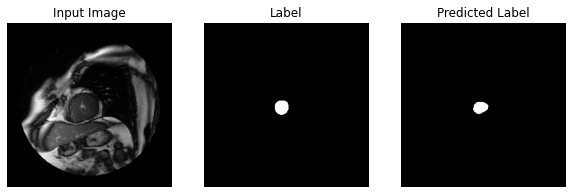


Sample prediction after epoch 23

234/234 [==============================] - 1s 6ms/step - loss: 0.0024 - dice_coef: 0.9482 - accuracy: 0.9990 - val_loss: 0.0088 - val_dice_coef: 0.8584 - val_accuracy: 0.9974
Epoch 24/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0023 - dice_coef: 0.9542 - accuracy: 0.9990

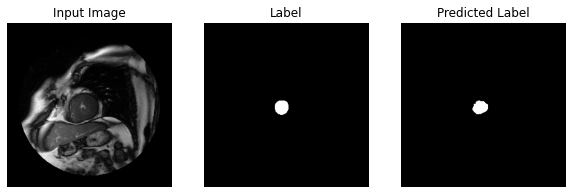


Sample prediction after epoch 24

234/234 [==============================] - 1s 6ms/step - loss: 0.0023 - dice_coef: 0.9533 - accuracy: 0.9990 - val_loss: 0.0091 - val_dice_coef: 0.8493 - val_accuracy: 0.9975
Epoch 25/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0023 - dice_coef: 0.9467 - accuracy: 0.9990

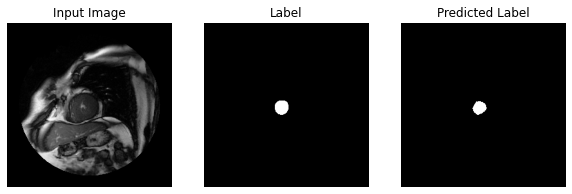


Sample prediction after epoch 25

234/234 [==============================] - 1s 6ms/step - loss: 0.0023 - dice_coef: 0.9474 - accuracy: 0.9990 - val_loss: 0.0092 - val_dice_coef: 0.8522 - val_accuracy: 0.9976
Epoch 26/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0021 - dice_coef: 0.9506 - accuracy: 0.9991

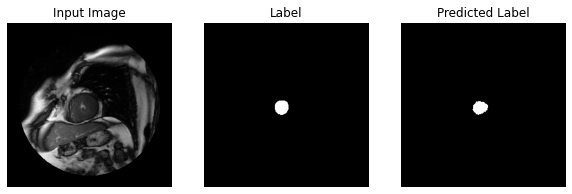


Sample prediction after epoch 26

234/234 [==============================] - 1s 6ms/step - loss: 0.0021 - dice_coef: 0.9506 - accuracy: 0.9991 - val_loss: 0.0084 - val_dice_coef: 0.8641 - val_accuracy: 0.9976
Epoch 27/30
223/234 [===========================>..] - ETA: 0s - loss: 0.0021 - dice_coef: 0.9521 - accuracy: 0.9991

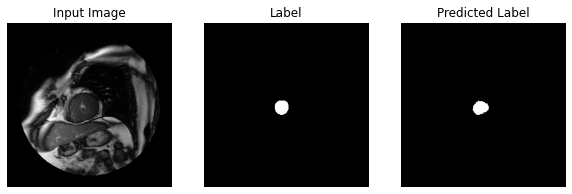


Sample prediction after epoch 27

234/234 [==============================] - 1s 6ms/step - loss: 0.0021 - dice_coef: 0.9528 - accuracy: 0.9991 - val_loss: 0.0085 - val_dice_coef: 0.8566 - val_accuracy: 0.9977
Epoch 28/30
233/234 [============================>.] - ETA: 0s - loss: 0.0021 - dice_coef: 0.9574 - accuracy: 0.9991

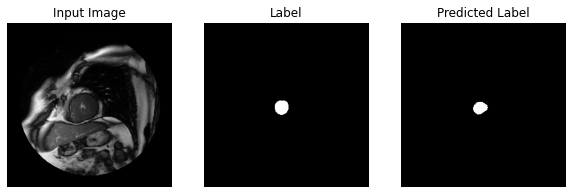


Sample prediction after epoch 28

234/234 [==============================] - 2s 6ms/step - loss: 0.0021 - dice_coef: 0.9575 - accuracy: 0.9991 - val_loss: 0.0085 - val_dice_coef: 0.8497 - val_accuracy: 0.9976
Epoch 29/30
223/234 [===========================>..] - ETA: 0s - loss: 0.0020 - dice_coef: 0.9563 - accuracy: 0.9991

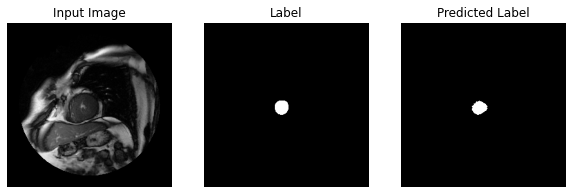


Sample prediction after epoch 29

234/234 [==============================] - 1s 6ms/step - loss: 0.0021 - dice_coef: 0.9565 - accuracy: 0.9991 - val_loss: 0.0100 - val_dice_coef: 0.8532 - val_accuracy: 0.9974
Epoch 30/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0022 - dice_coef: 0.9555 - accuracy: 0.9991

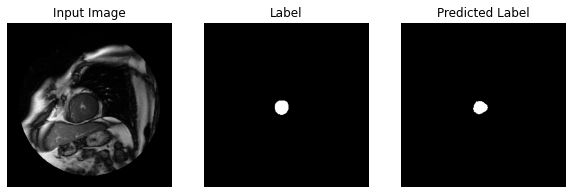


Sample prediction after epoch 30

234/234 [==============================] - 1s 6ms/step - loss: 0.0022 - dice_coef: 0.9555 - accuracy: 0.9991 - val_loss: 0.0104 - val_dice_coef: 0.8386 - val_accuracy: 0.9973


In [43]:
# setup and run the module
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))

model_history = model.fit(train_dataset, epochs=EPOCHS,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_data=test_dataset,
                         callbacks=[DisplayCallback()])

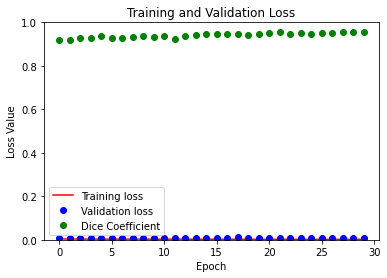

In [45]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()
